# Topik yang dipilih : Ibu kota negara baru Indonesia, Nusantara

### Business Understanding
Alasan memilih topik : 
1. topik yang sering dibicarakan baik di twitter maupun di media cetak
2. merupakan calon ikon baru Indonesia
3. penuh dengan pro kontra karena diadakan di tengah pandemi dan permasalahan negara lainnya

Apa yang berusaha kalian cari :
1. Perbandingan topik yang dibahas mengenai ibu kota negara baru di twitter dan kompas : Topic modelling
2. Melihat keberpihakan netizen di twitter : Sentiment Analysis

Apa tujuan kalian :
1. Mengetahui perkembangan lebih lanjut Ibu kota negara baru
2. Mengetahui alasan rakyat mendukung dan tidak

In [3]:
#library & package. 
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import json, tweepy, requests, re, nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import datetime
from urllib.request import urlopen
from bs4 import BeautifulSoup
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import tqdm
from pprint import pprint
from wordcloud import WordCloud
plt.style.use('seaborn')

In [7]:
# Data Collection 1 : Mengumpulkan dataset dari twitter selama 4 hari ke belakang
# Menggunakan token dari sanbercode untuk data_ikn.csv dengan topics ibukota negara

# buka file json berisi token twitter API
with open("token.json")as f:
  tokens = json.load(f)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

#buat variabel authentikasi dan api
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit = True)
# api = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit = True)

def user_timeline_scraper(topics):
    # digunakan saat menggunakan token sanber yang menggunakan API v1 
    # ditambahkan pada topics dengan days dimasukkan ke since dan today dimasukkan ke until
    today = datetime.date.today()
    days = today-datetime.timedelta(days=4)
    response = tweepy.Cursor(api.search_tweets, q=topics+" since:"+str(days)+" until:"+str(today), lang='id', tweet_mode='extended').items()
    berita = []
    for tweet in response :
        berita.append([tweet.user.screen_name, str(tweet.created_at.date()), tweet.full_text])
    df = pd.DataFrame(berita, columns=['name', 'post at', 'tweets']) 
    return df
        
topics = "ibu kota negara baru -filter:retweets" 
df_tweets = user_timeline_scraper(topics)
df_tweets

,name,post at,tweets
0,ballambinlove,2022-03-03,"@marlina_idha Pada 1999, Malaysia memutuskan u..."
1,MongabayID,2022-03-03,Pesisir Ibu Kota Negara Baru Dijanjikan Akan B...
2,QueenDibaaa,2022-03-03,Irjen Dedi mengatakan tak ada personel Polri y...
3,haibundacom,2022-03-03,Besaran tunjangan Pegawai Negeri Sipil (PNS) y...
4,gadisresidu_b3,2022-03-03,8.harus mengakhiri masa jabatannya pada 2024 s...
...,...,...,...
275,WellOne11,2022-02-28,Ibu Kota Negara Baru Akan Jadi Superhub Ekonom...
276,roseuune,2022-02-28,Ibu Kota Negara baru dirancang dapat menciptak...
277,akuyanggendut,2022-02-28,Ibu Kota Negara baru dirancang untuk dapat men...
278,aktualofficial,2022-02-28,"Lompatan Transformasi, Kenal Lebih Dekat Denga..."


In [8]:
# menyimpan data mentah ke csv
df_tweets.to_csv('data_ikn_news22.csv')

In [46]:
# Data Collection 2 : Menggunakan sumber data tambahan dengan webscrapping dari kompas.com selama 4 hari ke belakang
# Data ini untuk melihat berita yang ada membahas IKN (akan ada filtering data)

# pengambilan tanggal judul berita
tanggal = ["2022-02-28", "2022-03-01", "2022-03-02", "2022-03-03", "2022-03-04"]
berita = []

for i in range(len(tanggal)):
    for page in range(1,11): #kita tilik judul berita hingga halaman ke-10
        alamat = "https://news.kompas.com/search/"+tanggal[i]+"/"+str(page)
        html = urlopen(alamat)
        data = BeautifulSoup(html, 'html.parser')
        
        # cari letak judul berita secara keseluruhan menggunakan inspect
        div = data.findAll("div", {"class":"latest--news mt2 clearfix"})

        for row in div:
            # cari letak judul yang lebih pasti
            for cell in row.findAll(["h3"]):
                berita.append([tanggal[i], cell.get_text()]) #simpan dalam list

df = pd.DataFrame(berita, columns=['tanggal','title']) # simpan dalam dataframe
df

,tanggal,title
0,2022-02-28,PPKM Luar Jawa-Bali Diperpanjang 1-14 Maret 20...
1,2022-02-28,Toko Elektronik hingga Bengkel di Bekasi Dilan...
2,2022-02-28,"Pedagang Daging Sapi Mogok Jualan, RPH di Tang..."
3,2022-02-28,Pemerintah Resmi Perpanjang PPKM Jawa-Bali 1-7...
4,2022-02-28,UPDATE 28 Februari: Ada 7.300 Kasus Baru Covid...
...,...,...
649,2022-03-04,Prakiraan Cuaca BMKG: Sebagian Jakarta Diguyur...
650,2022-03-04,5 Unsur Pokok Terbentuknya Masyarakat Madani
651,2022-03-04,Pembagian Kekuasaan dalam Kerangka Otonomi Daerah
652,2022-03-04,Hakikat Otonomi Daerah


In [55]:
# simpan data judul berita ke dalam csv
df.to_csv('data_kompas.csv')

In [4]:
# Load file mentah hasil data collection
df_twitter = pd.read_csv('data_ikn_news22.csv', usecols =['name', 'post at', 'tweets']) 
df_kompas = pd.read_csv('data_kompas.csv', usecols = ['tanggal', 'title'])

In [5]:
# Menilik kedua file mentah
print("Data Twitter")
display(df_twitter.head())
print("Data Kompas")
display(df_kompas.head())

Data Twitter


,name,post at,tweets
0,ballambinlove,2022-03-03,"@marlina_idha Pada 1999, Malaysia memutuskan u..."
1,MongabayID,2022-03-03,Pesisir Ibu Kota Negara Baru Dijanjikan Akan B...
2,QueenDibaaa,2022-03-03,Irjen Dedi mengatakan tak ada personel Polri y...
3,haibundacom,2022-03-03,Besaran tunjangan Pegawai Negeri Sipil (PNS) y...
4,gadisresidu_b3,2022-03-03,8.harus mengakhiri masa jabatannya pada 2024 s...


Data Kompas


,tanggal,title
0,2022-02-28,PPKM Luar Jawa-Bali Diperpanjang 1-14 Maret 20...
1,2022-02-28,Toko Elektronik hingga Bengkel di Bekasi Dilan...
2,2022-02-28,"Pedagang Daging Sapi Mogok Jualan, RPH di Tang..."
3,2022-02-28,Pemerintah Resmi Perpanjang PPKM Jawa-Bali 1-7...
4,2022-02-28,UPDATE 28 Februari: Ada 7.300 Kasus Baru Covid...


In [6]:
# Data preparation 1 : Khusus data dari kompas
# Memfilter dengan judul memiliki kata ikn/ibu kota negara
a = df_kompas[df_kompas['title'].str.find('IKN')>-1]
b = df_kompas[df_kompas['title'].str.find('Ibu Kota Negara')>-1]
frame = [a, b]
df_kompas_ikn = pd.concat(frame)
df_kompas_ikn = df_kompas_ikn.sort_values('tanggal', ascending=True).reset_index(drop=True)
df_kompas_ikn

,tanggal,title
0,2022-03-01,"Dinilai Tak Efektif Cegah Banjir Jakarta, Sumu..."
1,2022-03-01,"Bicara soal Kesetiaan Tentara, Jokowi Ingatkan..."
2,2022-03-01,Puan Usulkan Lokasi Istana Negara di IKN Diapi...
3,2022-03-01,Menpan RB: Skenario Pemindahan ASN ke IKN Nusa...
4,2022-03-01,Menpan RB: ASN Tak Bisa Beralasan Tak Mau Pind...
5,2022-03-01,Pakar Harap Calon Kepala Otorita IKN dari Prof...
6,2022-03-01,Alasan Jokowi Pindahkan Ibu Kota Negara: Pemer...
7,2022-03-02,Jokowi Geram Grup WhatsApp TNI Bahas Tolak IKN...
8,2022-03-02,"Pemindahan Ibu Kota Negara: Gagasan Soekarno, ..."
9,2022-03-02,"Dalam Sidang Munarman, Rocky Gerung Sentil Jok..."


In [7]:
# Data Preparation 1 : Text Preprocessing

# Fungsi untuk mengubah huruf menjadi lower, menghilangkan @, menghilangkan https, menghilangkan tanda baca, menghilangkan angka
# menghilangkan kata-kata slang, menghilangkan stopwords
def cleaner(data): 
    # casefolding
    data = data.lower() #lowercase
    data = re.sub("([@][A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(https\S+)|(\d+)"," ",str(data))
    
    # Slangremover
    f = open("slangwords.txt", "r")
    slangwords = json.loads(f.read())
    
    result = []
    word_list = []       
    for word in word_tokenize(data):
        if slangwords.get(word.lower()):
            word = slangwords[word.lower()]
        word_list.append(word)
    result.append(' '.join(word_list))  
    data = result[0]

    # stopwords
    sw = StopWordRemoverFactory().get_stop_words()
    data = ([word for word in word_tokenize(data) if word not in sw]) #eliminasi stopwords
    data = ' '.join(data)
    return data

In [8]:
df_twitter['tweets_clean'] = df_twitter['tweets'].apply(cleaner)
df_kompas_ikn['title_clean'] = df_kompas_ikn['title'].apply(cleaner)
df_twitter.to_csv('data_ikn_news22_clean.csv', index=False)
df_kompas_ikn.to_csv('data_kompas_clean.csv', index=False)

In [10]:
# Menilik hasil clean kedua data
print("Data Twitter")
display(df_twitter.head())
print("Data Kompas")
display(df_kompas_ikn.head())

Data Twitter


,name,post at,tweets,tweets_clean
0,ballambinlove,2022-03-03,"@marlina_idha Pada 1999, Malaysia memutuskan u...",malaysia memutuskan memindahkan ibu kota negar...
1,MongabayID,2022-03-03,Pesisir Ibu Kota Negara Baru Dijanjikan Akan B...,pesisir ibu kota negara baru dijanjikan berkel...
2,QueenDibaaa,2022-03-03,Irjen Dedi mengatakan tak ada personel Polri y...,irjen dedi mengatakan tak personel polri menol...
3,haibundacom,2022-03-03,Besaran tunjangan Pegawai Negeri Sipil (PNS) y...,besaran tunjangan pegawai negeri sipil pns pin...
4,gadisresidu_b3,2022-03-03,8.harus mengakhiri masa jabatannya pada 2024 s...,mengakhiri masa jabatannya sesuai konstitusi b...


Data Kompas


,tanggal,title,title_clean
0,2022-03-01,"Dinilai Tak Efektif Cegah Banjir Jakarta, Sumu...",dinilai tak efektif cegah banjir jakarta sumur...
1,2022-03-01,"Bicara soal Kesetiaan Tentara, Jokowi Ingatkan...",bicara soal kesetiaan tentara jokowi ingatkan ...
2,2022-03-01,Puan Usulkan Lokasi Istana Negara di IKN Diapi...,puan usulkan lokasi istana negara ibu kota neg...
3,2022-03-01,Menpan RB: Skenario Pemindahan ASN ke IKN Nusa...,menpan rb skenario pemindahan asn ibu kota neg...
4,2022-03-01,Menpan RB: ASN Tak Bisa Beralasan Tak Mau Pind...,menpan rb asn tak beralasan tak mau pindah ibu...


In [11]:
# Data Preparation 3 : EDA - Text Analysis

# Distribusi Frekuensi jumlah karakter per tweet/judul
def freq_char(df, tipe):
    bin_range = np.arange(0,280,10)
    fig, ax = plt.subplots(figsize=(10,6))
    df[tipe+'_clean'].str.len().hist(bins=bin_range, ax=ax);
    ax.set(title='Distribusi Frekuensi Jumlah Karakter per '+tipe, xlabel='jumlah karakter', ylabel='jumlah '+tipe);

# Distribusi panjang kata per tweet/judul
def freq_lenchar(df, tipe):
    bin_range = np.arange(0,30)
    fig, ax = plt.subplots(figsize=(10,6))
    df[tipe+'_clean'].str.split().map(lambda x:len(x)).hist(bins=bin_range, ax=ax)
    ax.set(title='Distribusi Frekuensi Jumlah Kata per '+tipe, xlabel='jumlah kata', ylabel='jumlah '+tipe);

# Distribusi panjang kata rata-rata per tweet/judul
def freq_mean_lenchar(df, tipe):
    fig, ax = plt.subplots(figsize=(10,6))
    df[tipe+'_clean'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x:np.mean(x)).hist(ax=ax)
    ax.set(title='Distribusi panjang kata rata-rata per '+tipe, xlabel='jumlah rata-rata karakter per kata', ylabel='jumlah '+tipe);

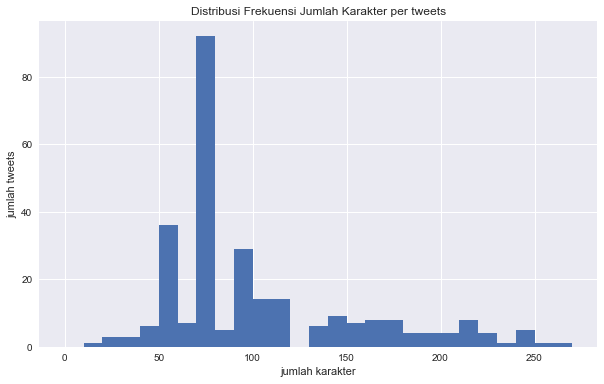

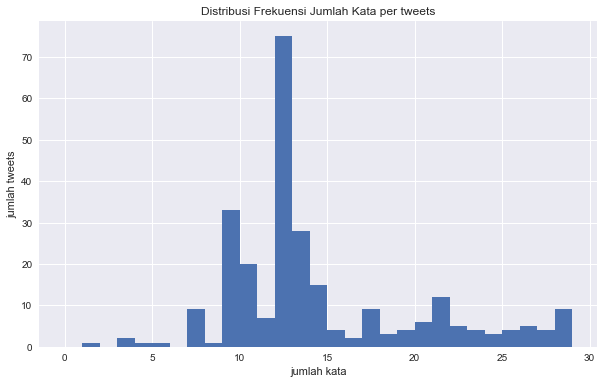

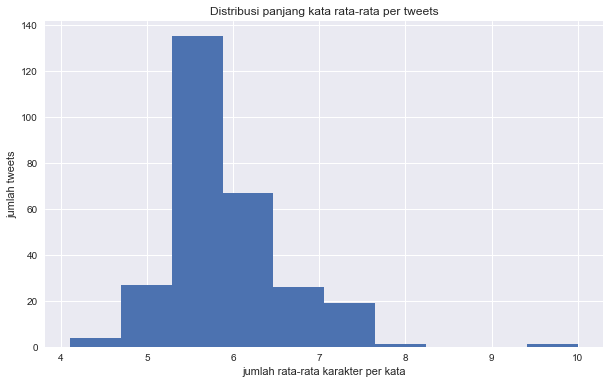

In [12]:
#Twitter
freq_char(df_twitter, 'tweets')
freq_lenchar(df_twitter, 'tweets')
freq_mean_lenchar(df_twitter, 'tweets')

### Data Analysis 
Dari data twitter di atas, kita peroleh:
data twitter rata-rata terdiri dari 80 karakter per tweets dengan 13 kata dan rata-rata karakter per katanya sebanyak 5-6 karakter.

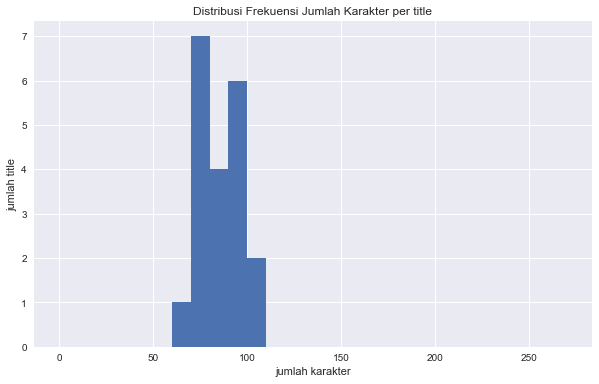

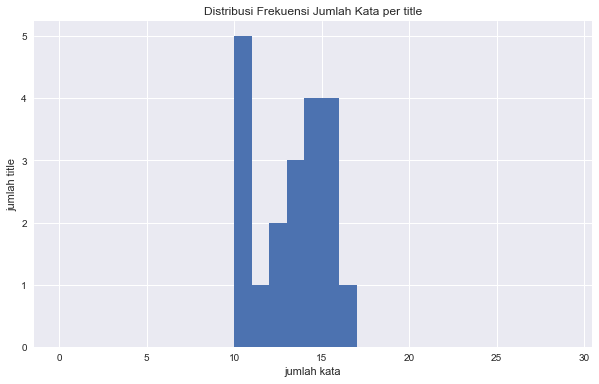

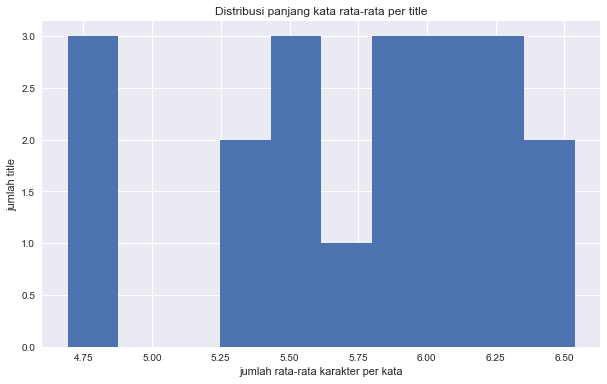

In [13]:
# Kompas
#Twitter
freq_char(df_kompas_ikn, 'title')
freq_lenchar(df_kompas_ikn, 'title')
freq_mean_lenchar(df_kompas_ikn, 'title')

### Data Analysis
Dari data kompas, diperoleh bahwa judul memiliki 70-100 karakter per judul dengan jumlah katanya sebanyak 10-15 kata dan per kata rata-rata 5-6 huruf.

In [14]:
# Data Preparation 3 : EDA - Text Analysis

# Frekuensi kemunculan kata
def fqdist (df, tipe) :
    clean = df[tipe+'_clean'].apply(word_tokenize)
    data = [word for d in clean for word in d]
    fqdist = FreqDist(data)
    most_common_word = fqdist.most_common(100)  # 100 kata paling sering muncul untuk deteksi kata slang
    print(most_common_word)
    fqdist.plot(20, cumulative=False); # plot top 20 kata paling sering muncul

Frekuensi kemunculan kata pada data Twitter 

[('kota', 364), ('negara', 360), ('ibu', 355), ('baru', 290), ('prokes', 154), ('jangan', 114), ('kendor', 101), ('kepala', 85), ('city', 84), ('intelligent', 82), ('bin', 81), ('bicara', 81), ('pemindahan', 64), ('indonesia', 57), ('masyarakat', 52), ('taat', 49), ('pembangunan', 41), ('ekonomi', 37), ('jadi', 36), ('dukung', 36), ('menjadi', 28), ('kalimantan', 24), ('sejarah', 21), ('superhub', 20), ('pindah', 19), ('usaha', 19), ('penopangnya', 19), ('presiden', 15), ('nusantara', 13), ('klaster', 13), ('masa', 12), ('timur', 12), ('polri', 10), ('joko', 10), ('widodo', 10), ('merupakan', 10), ('gerakan', 10), ('disiplin', 10), ('masker', 10), ('bangsa', 10), ('pandemi', 9), ('transformasi', 9), ('asn', 9), ('depan', 9), ('pns', 8), ('bagian', 8), ('bermanfaat', 8), ('banyak', 8), ('jakarta', 8), ('pemerataan', 8), ('seluruh', 8), ('percaya', 8), ('kaum', 8), ('menyesatkan', 8), ('kepentingan', 8), ('ikon', 8), ('tak', 7), ('jokowi', 7)

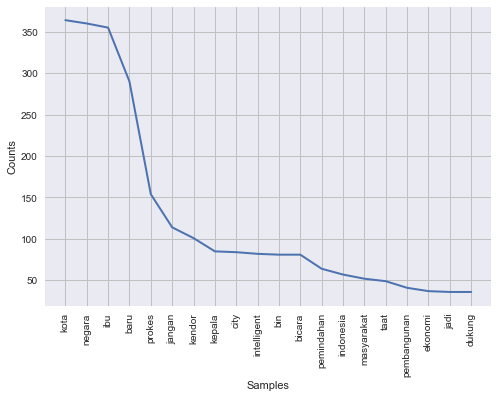

Frekuensi kemunculan kata pada data Kompas 

[('negara', 21), ('ibu', 20), ('kota', 20), ('tni', 9), ('jokowi', 8), ('soal', 6), ('whatsapp', 5), ('hati', 4), ('pemindahan', 4), ('dinilai', 3), ('tak', 3), ('polri', 3), ('asn', 3), ('nusantara', 3), ('grup', 3), ('ingatkan', 2), ('anggota', 2), ('menpan', 2), ('rb', 2), ('skenario', 2), ('hingga', 2), ('bahas', 2), ('tolak', 2), ('ksad', 2), ('jangan', 2), ('aneh', 2), ('nasional', 2), ('bappenas', 2), ('singgung', 2), ('debat', 2), ('baru', 2), ('efektif', 1), ('cegah', 1), ('banjir', 1), ('jakarta', 1), ('sumur', 1), ('resapan', 1), ('ala', 1), ('anies', 1), ('malah', 1), ('digunakan', 1), ('bicara', 1), ('kesetiaan', 1), ('tentara', 1), ('berdebat', 1), ('puan', 1), ('usulkan', 1), ('lokasi', 1), ('istana', 1), ('diapit', 1), ('mabes', 1), ('alasannya', 1), ('terus', 1), ('dimatangkan', 1), ('beralasan', 1), ('mau', 1), ('pindah', 1), ('hukumnya', 1), ('wajib', 1), ('pakar', 1), ('harap', 1), ('calon', 1), ('kepala', 1), ('otorita',

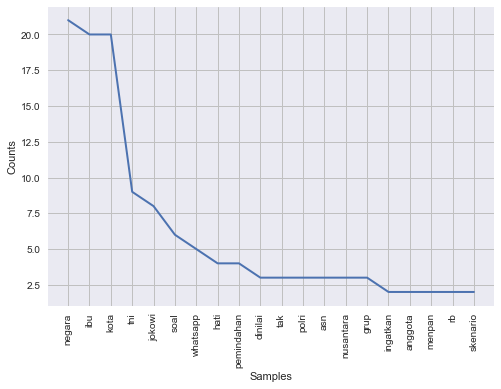

In [15]:
print("Frekuensi kemunculan kata pada data Twitter \n")
fqdist(df_twitter, 'tweets')
print("Frekuensi kemunculan kata pada data Kompas \n")
fqdist(df_kompas_ikn, 'title')

### Data Analysis
Pada data twitter dari hasil pencarian diperoleh bahwa kebanyakan dibahas mengenai kepala BIN bicara mengenai intelligent city dan pemindahan ibu kota negara untuk pembangunan ekonomi. 

Pada data kompas dari hasil pencarian diperoleh berita kebanyakan membahas mengenai grup whatsapp di TNI yang membahas penolakan IKN baru dan pemindahan asn ke IKN baru. 

In [16]:
# Data Preparation 3 : EDA - Text Analysis

def wordcloud_visualization(df, tipe):
    clean = df[tipe+'_clean'].apply(word_tokenize)
    result = [word for d in clean for word in d]
    wcloud = WordCloud(width=1600, height=800, max_font_size=180).generate(' '.join(result))
    plt.figure(figsize=(12,8))
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Frekuensi kemunculan kata pada data Twitter


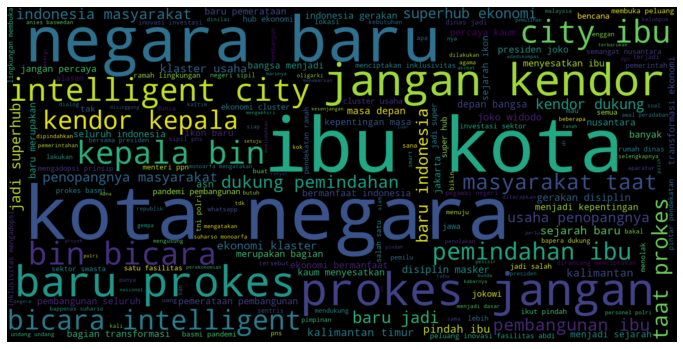

Frekuensi kemunculan kata pada data Kompas


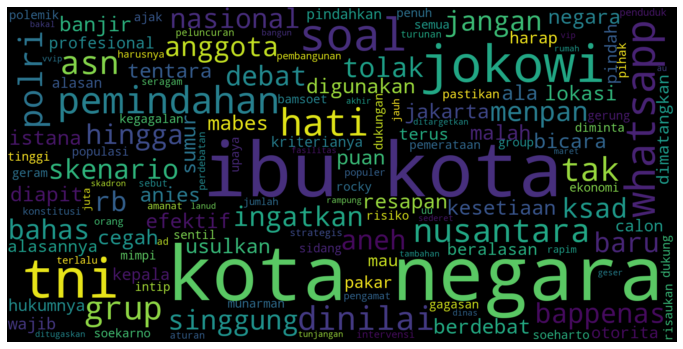

In [17]:
print("Frekuensi kemunculan kata pada data Twitter")
wordcloud_visualization(df_twitter, 'tweets')
print("Frekuensi kemunculan kata pada data Kompas")
wordcloud_visualization(df_kompas_ikn, 'title')

In [32]:
# Distribusi bi-gram untuk Data Twitter
clean = df_twitter['tweets_clean'].apply(word_tokenize)
data = [word for d in clean for word in d]
    
result = pd.Series(nltk.ngrams(data,2)).value_counts()[:20]
print(result)

(ibu, kota)              355
(kota, negara)           339
(negara, baru)           239
(prokes, jangan)         104
(jangan, kendor)         101
(baru, prokes)            93
(city, ibu)               82
(intelligent, city)       82
(bicara, intelligent)     81
(bin, bicara)             81
(kepala, bin)             81
(kendor, kepala)          69
(pemindahan, ibu)         60
(taat, prokes)            49
(masyarakat, taat)        49
(negara, ibu)             36
(pembangunan, ibu)        29
(dukung, pemindahan)      29
(baru, jadi)              26
(prokes, ibu)             25
dtype: int64


### Data Analysis
Kebanyakan kata pada Twitter mengenai kepala BIN dan dukung pemindahan

In [33]:
# Distribusi bi-gram untuk Data Kompas
cleank = df_kompas_ikn['title_clean'].apply(word_tokenize)
datak = [word for d in cleank for word in d]
    
result = pd.Series(nltk.ngrams(datak,2)).value_counts()[:20]
print(result)

(ibu, kota)               20
(kota, negara)            20
(soal, ibu)                4
(negara, nusantara)        3
(whatsapp, tni)            3
(pemindahan, ibu)          3
(grup, whatsapp)           3
(tni, polri)               3
(baru, tni)                2
(ingatkan, anggota)        2
(menpan, rb)               2
(jokowi, dinilai)          2
(hati, hati)               2
(tni, soal)                2
(tolak, ibu)               2
(bappenas, skenario)       1
(skenario, jumlah)         1
(konstitusi, bappenas)     1
(jumlah, penduduk)         1
(dinilai, tak)             1
dtype: int64


### Data Analysis
Kebanyakan judul kompas membahas mengenai whatsapp grup TNI dan skenario pemindahan ASN oleh Menpan RB

In [18]:
# Data Processing 1 : Topic Modeling

# maping kata pada tiap data
def maping(df, tipe) :
    # tipe untuk menambahkan nama column di dataframe masing2 ada tweets_clean untuk Twitter dan title_clean untuk Kompas
    berita = [words.split() for words in df[tipe+'_clean']]
    dictionary = corpora.Dictionary(berita)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in berita] # mengubah document (list of words) menjadi bag of words (list of token_id, token_count)
    return berita, dictionary, doc_term_matrix

# Membuat model LDA
def lda_model(dictionary, doc_term_matrix, num_topics, a=0.01, b=0.01) :
    ldamodel = LdaModel(random_state = 100,
                       chunksize = 100,
                       per_word_topics = True, 
                       corpus = doc_term_matrix,
                       num_topics = num_topics,
                       id2word = dictionary,
                       passes = 20,
                       alpha = a,
                       eta = b)
    return ldamodel

# Menampilkan hasil modeling
def base_topic_modeling(berita, dictionary, doc_term_matrix, num_topics, a=0.01, b=0.01) :
    ldamodel = lda_model(dictionary, doc_term_matrix, num_topics, a, b)
    coh_val_lda = CoherenceModel(model=ldamodel, texts=berita, dictionary=dictionary, coherence='c_v')
    coherence_lda = coh_val_lda.get_coherence()
    print("Coherence Score:", coherence_lda)
    
    # hasil modeling 
    return pprint(ldamodel.print_topics())

In [19]:
# Membuat topic modelling mencari jumlah topic terbaik

# Optimization 
def compute_coherence_value(berita, corpus, dictionary, k, a, b):
    ldamodel = LdaModel(random_state = 100,
                   chunksize = 100,
                   per_word_topics = True, 
                   corpus = corpus,
                   num_topics = k,
                   id2word = dictionary,
                   passes = 20, 
                   alpha = a,
                   eta = b)
    coh_val_lda = CoherenceModel(model=ldamodel, texts=berita, dictionary=dictionary, coherence='c_v')
    coherence_lda = coh_val_lda.get_coherence()
    return coherence_lda

def opt(berita, dictionary, doc_term_matrix, min_topics, max_topics, step_size, topics) :
    #Topic range 
    topics_range = range(min_topics, max_topics, step_size)

    #Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.2))
    alpha.extend(['symmetric', 'asymmetric'])

    #Beta parameter
    beta = list(np.arange(0.01, 1, 0.2))
    beta.append('symmetric')

    #Validation sets
    num_of_docs = len(doc_term_matrix)
    corpus_sets = [gensim.utils.ClippedCorpus(doc_term_matrix, int(num_of_docs*0.75)), doc_term_matrix]
    corpus_title = ['75% Corpus', '100% Corpus']
    model_results = {'validation_sets':[],
                    'topics': [],
                    'alpha': [],
                    'beta':[],
                    'coherence':[]}

    pbar = tqdm.tqdm(total=336)
    #iterate for validation
    for i in range(len(corpus_sets)):
        #iterate for topics
        for k in topics_range:
            #iterate for alpha
            for a in alpha:
                #iterate for beta
                for b in beta:
                    #get coherence value
                    cv = compute_coherence_value(berita=berita, corpus=corpus_sets[i], dictionary=dictionary, k=k, a=a, b=b)
                    #save models
                    model_results['validation_sets'].append(corpus_title[i])
                    model_results['topics'].append(k)
                    model_results['alpha'].append(a)
                    model_results['beta'].append(b)
                    model_results['coherence'].append(cv)

                    pbar.update(1)

    #save to csv
    df = pd.DataFrame(model_results)
    df.to_csv(topics+'_results.csv', index=False)
    pbar.close()
    return df

In [20]:
# Maping kata pada Twitter dan Kompas
berita_twitter, dict_twitter, doc_term_twitter = maping(df_twitter, 'tweets')
berita_kompas, dict_kompas, doc_term_kompas = maping(df_kompas_ikn, 'title')

In [115]:
print("Topic Modelling Optimization Data Twitter")
opt(berita=berita_twitter, dictionary=dict_twitter, doc_term_matrix=doc_term_twitter, min_topics=2, max_topics=6, step_size=1, topics='twitter')

Topic Modelling Optimization Data Twitter



 39%|███████████████████████████████▏                                                | 131/336 [33:32<50:29, 14.78s/it]


 78%|█████████████████████████████████████████████████████████████                 | 263/336 [1:07:48<19:35, 16.11s/it]


100%|██████████████████████████████████████████████████████████████████████████████| 336/336 [1:18:20<00:00, 13.99s/it]


,validation_sets,topics,alpha,beta,coherence
0,75% Corpus,2,0.01,0.01,0.369008
1,75% Corpus,2,0.01,0.21,0.377946
2,75% Corpus,2,0.01,0.41,0.375180
3,75% Corpus,2,0.01,0.61,0.379819
4,75% Corpus,2,0.01,0.81,0.332480
...,...,...,...,...,...
331,100% Corpus,5,asymmetric,0.21,0.378111
332,100% Corpus,5,asymmetric,0.41,0.373580
333,100% Corpus,5,asymmetric,0.61,0.346299
334,100% Corpus,5,asymmetric,0.81,0.347191


In [116]:
print("Topic Modelling Optimization Data Twitter")
opt(berita=berita_kompas, dictionary=dict_kompas, doc_term_matrix=doc_term_kompas, min_topics=2, max_topics=6, step_size=1, topics='kompas')

Topic Modelling Optimization Data Twitter



 39%|███████████████████████████████▏                                                | 131/336 [06:46<10:41,  3.13s/it]


 78%|██████████████████████████████████████████████████████████████▌                 | 263/336 [13:49<03:42,  3.05s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 336/336 [17:49<00:00,  3.18s/it]


,validation_sets,topics,alpha,beta,coherence
0,75% Corpus,2,0.01,0.01,0.391116
1,75% Corpus,2,0.01,0.21,0.399701
2,75% Corpus,2,0.01,0.41,0.386450
3,75% Corpus,2,0.01,0.61,0.380946
4,75% Corpus,2,0.01,0.81,0.338610
...,...,...,...,...,...
331,100% Corpus,5,asymmetric,0.21,0.353950
332,100% Corpus,5,asymmetric,0.41,0.344163
333,100% Corpus,5,asymmetric,0.61,0.345040
334,100% Corpus,5,asymmetric,0.81,0.338809


In [117]:
opt_twitter = pd.read_csv('twitter_results.csv')
opt_kompas = pd.read_csv('kompas_results.csv')

print('Twitter')
display(opt_twitter.sort_values('coherence', ascending=False)[:10])
print('Kompas')
display(opt_kompas.sort_values('coherence', ascending=False)[:10])

Twitter


,validation_sets,topics,alpha,beta,coherence
330,100% Corpus,5,asymmetric,0.01,0.491631
162,75% Corpus,5,asymmetric,0.01,0.478035
167,75% Corpus,5,asymmetric,symmetric,0.467159
163,75% Corpus,5,asymmetric,0.21000000000000002,0.460315
164,75% Corpus,5,asymmetric,0.41000000000000003,0.453483
288,100% Corpus,4,asymmetric,0.01,0.432203
143,75% Corpus,5,0.41000000000000003,symmetric,0.429735
151,75% Corpus,5,0.81,0.21000000000000002,0.428087
139,75% Corpus,5,0.41000000000000003,0.21000000000000002,0.425842
252,100% Corpus,4,0.01,0.01,0.423522


Kompas


,validation_sets,topics,alpha,beta,coherence
121,75% Corpus,4,asymmetric,0.21000000000000002,0.403524
125,75% Corpus,4,asymmetric,symmetric,0.403524
1,75% Corpus,2,0.01,0.21000000000000002,0.399701
79,75% Corpus,3,asymmetric,0.21000000000000002,0.395105
120,75% Corpus,4,asymmetric,0.01,0.393487
183,100% Corpus,2,0.41000000000000003,0.6100000000000001,0.393056
184,100% Corpus,2,0.41000000000000003,0.81,0.393056
122,75% Corpus,4,asymmetric,0.41000000000000003,0.392045
0,75% Corpus,2,0.01,0.01,0.391116
291,100% Corpus,4,asymmetric,0.6100000000000001,0.387047


In [21]:
print("After Optimization: topic modeling data Twitter")
base_topic_modeling(berita_twitter, dict_twitter, doc_term_twitter, 5, a='asymmetric', b=0.01)
print("After Optimization: topic modeling data Kompas")
base_topic_modeling(berita_kompas, dict_kompas, gensim.utils.ClippedCorpus(doc_term_kompas, int(len(doc_term_kompas)*0.75)), 4,a='asymmetric', b=0.21)

After Optimization: topic modeling data Twitter
Coherence Score: 0.34729089308434924
[(0,
  '0.197*"negara" + 0.195*"kota" + 0.187*"ibu" + 0.129*"baru" + '
  '0.054*"indonesia" + 0.042*"jadi" + 0.035*"pembangunan" + 0.025*"menjadi" + '
  '0.019*"kalimantan" + 0.017*"pindah"'),
 (1,
  '0.086*"prokes" + 0.082*"baru" + 0.082*"kota" + 0.080*"ibu" + 0.078*"negara" '
  '+ 0.055*"jangan" + 0.052*"kepala" + 0.051*"city" + 0.050*"intelligent" + '
  '0.049*"bicara"'),
 (2,
  '0.001*"mengesampingkan" + 0.001*"maksa" + 0.001*"payah" + 0.001*"pake" + '
  '0.001*"mensentralisasi" + 0.001*"pengen" + 0.001*"fanatik" + 0.001*"istri" '
  '+ 0.001*"dinaikan" + 0.001*"kekuasaan"'),
 (3,
  '0.111*"polri" + 0.093*"tak" + 0.066*"ibu" + 0.065*"kota" + '
  '0.065*"mengatakan" + 0.062*"negara" + 0.060*"menolak" + 0.044*"pimpinan" + '
  '0.042*"personel" + 0.042*"membangun"'),
 (4,
  '0.210*"pemindahan" + 0.138*"prokes" + 0.111*"dukung" + 0.105*"baru" + '
  '0.099*"ibu" + 0.097*"kota" + 0.095*"negara" + 0.068*"j

### Data Analysis 
Dari hasil optimization kita lihat masing-masing yang memiliki coherence value tertinggi :
1. Pada data twitter :
    - topik 1 membahas mengenai pemindahan IKN ke kalimantan
    - topik 2 membahas mengenai kepala BIN bicara intelligent city
    - topik 3 membahas kritikan mengenai sentralisasi kekuasaan
    - topik 4 membahas tak ada personel Polri yang menolak IKN
    - topik 5 membahas prokes jangan kendor
2. Pada data kompas :
    - topik 1 membahas Jokowi Geram grup WhatsApp TNI bahas tolak IKN
    - topik 2 membahas kesetiaan tentara mengenai tolak IKN
    - topik 3 membahas skenario pemindahan ASN 
    - topik 4 membahas Rocky sentil Jokowi yang melihat grup TNI
Pada data kompas ini, masih terdapat topik yang mirip sehingga nanti pada pengkategorian terdapat ada sedikit perubahan.

In [22]:
def topics_category(df, dictionary, doc_term_matrix, num_topics, a, b, judul):
    topic = lda_model(dictionary, doc_term_matrix, num_topics, a, b)
    
    count = 0
    filter_col = [col for col in df if col.startswith('topic')]
    df = df.drop(filter_col, axis=1)
    for i in range(num_topics):
        col_name = 'topic_'+str(i)
        df[col_name] = 0

    for i in topic[doc_term_matrix]:
        listA = i[0]
        for i in range(len(listA)):
            col_name = 'topic_'+str(listA[i][0]) 
            df.loc[count, col_name] = float(listA[i][1])
        count+=1

    df.to_csv(judul+'_topic_modelling.csv')
    return df

In [23]:
#Twitter
twit_topics = topics_category(df_twitter, dict_twitter, doc_term_twitter, 5,'asymmetric', 0.01,'Twitter')
twit_topics.style.background_gradient() #kita tandai pada bagian max di tiap rows

,name,post at,tweets,tweets_clean,topic_0,topic_1,topic_2,topic_3,topic_4
0,ballambinlove,2022-03-03,"@marlina_idha Pada 1999, Malaysia memutuskan untuk memindahkan Ibu Kota Negaranya ke Putrajaya sebagai kota administratif. Namun pemindahan tersebut dinilai gagal karena pegawai pemerintah Malaysia enggan pindah ke ibu kota negara baru. https://t.co/Mpako7hXch",malaysia memutuskan memindahkan ibu kota negaranya putrajaya kota administratif pemindahan tersebut dinilai gagal pegawai pemerintah malaysia enggan pindah ibu kota negara baru,0.290993,0.634779,0.000000,0.000000,0.060403
1,MongabayID,2022-03-03,Pesisir Ibu Kota Negara Baru Dijanjikan Akan Berkelanjutan https://t.co/Er1bCIFtnV,pesisir ibu kota negara baru dijanjikan berkelanjutan,0.181542,0.763772,0.021963,0.017792,0.014931
2,QueenDibaaa,2022-03-03,Irjen Dedi mengatakan tak ada personel Polri yang menolak Ibu Kota Negara (IKN) baru seperti yang disinggung Jokowi. Irjen Dedi mengatakan personel Polri setia dengan perintah pimpinan. https://t.co/qwKCNxHqjI,irjen dedi mengatakan tak personel polri menolak ibu kota negara ibu kota negara baru disinggung jokowi irjen dedi mengatakan personel polri setia perintah pimpinan,0.019041,0.000000,0.000000,0.959710,0.000000
3,haibundacom,2022-03-03,"Besaran tunjangan Pegawai Negeri Sipil (PNS) yang akan pindah ke Ibu Kota Negara (IKN) baru kabarnya bakal berubah menyesuaikan kebutuhan di sana, Bunda. https://t.co/AKkkzrsOps",besaran tunjangan pegawai negeri sipil pns pindah ibu kota negara ibu kota negara baru kabarnya bakal berubah menyesuaikan kebutuhan sana bunda,0.233379,0.746740,0.000000,0.000000,0.000000
4,gadisresidu_b3,2022-03-03,"8.harus mengakhiri masa jabatannya pada 2024 sesuai konstitusi (berkisar 68-71%), baik karena alasan pandemi, pemulihan ekonomi akibat pandemi, atau pembangunan Ibu Kota Negara baru. • Mayoritas warga juga lebih setuju bahwa pergantian kepemimpinan nasional melalui Pemilu 2024",mengakhiri masa jabatannya sesuai konstitusi berkisar baik alasan pandemi pemulihan ekonomi akibat pandemi pembangunan ibu kota negara baru mayoritas warga lebih setuju pergantian kepemimpinan nasional melalui pemilu,0.061778,0.922603,0.000000,0.000000,0.000000
5,KompasData,2022-03-03,"Pemindahan Ibu Kota Negara bertujuan untuk menekan kesenjangan perekonomian Jawa dan Luar Jawa. Belajar dari Brasil, pemindahan ibu kota perlu juga mewaspadai kemungkinan munculnya kesenjangan baru. @atmoberkicau #LitbangKompas #Kompaspedia #AdadiKompas https://t.co/pxFY8fkk2T",pemindahan ibu kota negara bertujuan menekan kesenjangan perekonomian jawa luar jawa belajar brasil pemindahan ibu kota perlu mewaspadai kemungkinan munculnya kesenjangan baru litbangkompas kompaspedia adadikompas,0.014054,0.866185,0.000000,0.000000,0.107530
6,YusufPulungan,2022-03-03,Ibu Kota Negara (IKN) Baru Bukan Untuk Rakyat Tapi Proyek Oligarki Kap... https://t.co/lyTsxKJ0PV lewat @YouTube,ibu kota negara ibu kota negara baru bukan rakyat proyek oligarki kap lewat,0.159320,0.809428,0.012551,0.010168,0.000000
7,TRIOKWEKKWEKkI2,2022-03-03,"@KangUtang04 @freedoml4nd3535 @L42454thie @negri_dongeng08 @JamanEdan543123 @SayRi31180709 @ManiseWidiarti @FattiReyz @M898black_Arrow @Cint4N @Ikotjo @Sis885 @Hilang8281 @PutraRa33763114 PEMERINTAHAN JOKOWI INI UDAH TUMBANG KAN, BOKEK KAN? Mana pemerintahan barunya? Segera pilih presiden baru lah. Butuh Uang Rp1000 Triliun Demi Ibu Kota Baru, Pemerintah Jual Tanah Negara https://t.co/zZtoCmZrKM #PresidenPengkhianatNegara",pemerintahan jokowi udah tumbang kan bokek kan mana pemerintahan barunya segera pilih presiden baru lah butuh uang rp triliun ibu kota baru pemerintah jual tanah negara presidenpengkhianatnegara,0.530638,0.453716,0.000000,0.000000,0.000000
8,Beritasatu,2022-03-03,"Menko Marves Luhut menawarkan Pangeran Salman peluang investasi dalam pembangunan Ibu Kota Negara baru, energi baru dan terbarukan, dll. Selengkapnya: 👇 #IbuKotaNegara https://t.co/nglgjE3frC",menko marves luhut menawarkan pangeran salman peluang invest

In [24]:
# Kompas
topics_category(df_kompas_ikn, dict_kompas, doc_term_kompas, 3, 'asymmetric', 0.21, 'Kompas').style.background_gradient()

,tanggal,title,title_clean,topic_0,topic_1,topic_2
0,2022-03-01,"Dinilai Tak Efektif Cegah Banjir Jakarta, Sumur Resapan ala Anies Malah Akan Digunakan di IKN",dinilai tak efektif cegah banjir jakarta sumur resapan ala anies malah digunakan ibu kota negara,0.965742,0.020408,0.013850
1,2022-03-01,"Bicara soal Kesetiaan Tentara, Jokowi Ingatkan Anggota TNI Hati-hati Berdebat soal IKN",bicara soal kesetiaan tentara jokowi ingatkan anggota tni hati hati berdebat soal ibu kota negara,0.043388,0.942775,0.013837
2,2022-03-01,"Puan Usulkan Lokasi Istana Negara di IKN Diapit Mabes TNI dan Polri, Ini Alasannya",puan usulkan lokasi istana negara ibu kota negara diapit mabes tni polri alasannya,0.043303,0.940879,0.015818
3,2022-03-01,Menpan RB: Skenario Pemindahan ASN ke IKN Nusantara Terus Dimatangkan,menpan rb skenario pemindahan asn ibu kota negara nusantara terus dimatangkan,0.952549,0.028991,0.018460
4,2022-03-01,"Menpan RB: ASN Tak Bisa Beralasan Tak Mau Pindah ke IKN, Hukumnya Wajib",menpan rb asn tak beralasan tak mau pindah ibu kota negara hukumnya wajib,0.040271,0.943913,0.015816
5,2022-03-01,"Pakar Harap Calon Kepala Otorita IKN dari Profesional, Ini Kriterianya...",pakar harap calon kepala otorita ibu kota negara profesional kriterianya,0.951655,0.028199,0.020147
6,2022-03-01,Alasan Jokowi Pindahkan Ibu Kota Negara: Pemerataan Ekonomi hingga Populasi,alasan jokowi pindahkan ibu kota negara pemerataan ekonomi hingga populasi,0.951565,0.028294,0.020141
7,2022-03-02,"Jokowi Geram Grup WhatsApp TNI Bahas Tolak IKN, KSAD: Jangan Ada yang Aneh-aneh!",jokowi geram grup whatsapp tni bahas tolak ibu kota negara ksad jangan aneh aneh,0.964561,0.020678,0.014761
8,2022-03-02,"Pemindahan Ibu Kota Negara: Gagasan Soekarno, Mimpi Soeharto, dan Upaya Jokowi",pemindahan ibu kota negara gagasan soekarno mimpi soeharto upaya jokowi,0.951297,0.028563,0.020141
9,2022-03-02,"Dalam Sidang Munarman, Rocky Gerung Sentil Jokowi yang Intip Grup WA TNI soal Tolak IKN",sidang munarman rocky gerung sentil jokowi intip grup whatsapp tni soal tolak ibu kota negara,0.966589,0.019568,0.013843


### Data Analysis 
Perubahan pada penggunaan model menjadi 3 topik :
- topik 1 membahas grup whatsapp TNI tentang penolakan IKN
- topik 2 membahas pemindahan ibu kota
- topik 3 membahas aturan turunan IKN

In [30]:
# Data Processing 2 : Sentiment Analysis polarity-based

def loadDatasetPembanding():
    positive_words = open("kata_positif.txt")
    negative_words = open("kata_negatif.txt")
    
    positive_words = positive_words.read().splitlines()
    negative_words = negative_words.read().splitlines()
    
    return positive_words, negative_words

def polarity(data):
    positive_words, negative_words = loadDatasetPembanding()

    p_polarity = 0
    n_polarity = 0
    
    list_negasi = ["tidak", "anti", "tak", "enggan", "jangan"]
    
    for word in word_tokenize(data):
        if word in positive_words and word not in list_negasi:
            p_polarity += 1
        elif word in list_negasi:
            n_polarity += 1
            
        if word in negative_words and word not in list_negasi:
            n_polarity += 1
        elif word in list_negasi:
            p_polarity += 1

    total_polarity = p_polarity - n_polarity

    if total_polarity>0 :
        return "positif"
    elif total_polarity<0 :
        return "negatif"
    else :
        return "netral"        

In [31]:
# Twitter
df_twitter['sentiment'] = df_twitter['tweets_clean'].apply(polarity)
df_twitter.to_csv('Sentimen_twitter.csv')
df_twitter.head()

,name,post at,tweets,tweets_clean,sentiment
0,ballambinlove,2022-03-03,"@marlina_idha Pada 1999, Malaysia memutuskan u...",malaysia memutuskan memindahkan ibu kota negar...,negatif
1,MongabayID,2022-03-03,Pesisir Ibu Kota Negara Baru Dijanjikan Akan B...,pesisir ibu kota negara baru dijanjikan berkel...,positif
2,QueenDibaaa,2022-03-03,Irjen Dedi mengatakan tak ada personel Polri y...,irjen dedi mengatakan tak personel polri menol...,negatif
3,haibundacom,2022-03-03,Besaran tunjangan Pegawai Negeri Sipil (PNS) y...,besaran tunjangan pegawai negeri sipil pns pin...,netral
4,gadisresidu_b3,2022-03-03,8.harus mengakhiri masa jabatannya pada 2024 s...,mengakhiri masa jabatannya sesuai konstitusi b...,positif


In [32]:
df_twitter.sentiment.value_counts()

positif    97
negatif    93
netral     90
Name: sentiment, dtype: int64

In [33]:
df_twitter[df_twitter.sentiment=="positif"].sample(20)

,name,post at,tweets,tweets_clean,sentiment
8,Beritasatu,2022-03-03,Menko Marves Luhut menawarkan Pangeran Salman ...,menko marves luhut menawarkan pangeran salman ...,positif
175,KharismaSang,2022-03-01,Undang-Undang tentang Ibu Kota Negara akan men...,undang undang ibu kota negara menjadi dasar pe...,positif
149,WeAre_GARUDA,2022-03-02,Indonesia Sentris.. \nTerwujudkan\nDgn peminda...,indonesia sentris terwujudkan dgn pemindahan i...,positif
235,Emayant63176260,2022-02-28,Pemindahan Ibu Kota Negara sejarah baru Indone...,pemindahan ibu kota negara sejarah baru indone...,positif
223,Eksia5,2022-02-28,Ibu Kota Negara baru akan jadi superhub ekonom...,ibu kota negara baru jadi superhub ekonomi kla...,positif
243,DinaCitra17,2022-02-28,Pemindahan Ibu Kota Negara sejarah baru Indone...,pemindahan ibu kota negara sejarah baru indone...,positif
156,DandiHandoko,2022-03-02,Mari kita dukung pemindahan Ibu Kota Negara ya...,dukung pemindahan ibu kota negara baru pemerat...,positif
1,MongabayID,2022-03-03,Pesisir Ibu Kota Negara Baru Dijanjikan Akan B...,pesisir ibu kota negara baru dijanjikan berkel...,positif
251,Windiyanty1,2022-02-28,Ibu kota negara baru akan jadi super hub ekono...,ibu kota negara baru jadi super hub ekonomi cl...,positif
258,IbuPertiwii,2022-02-28,Ini adalah alasan ibu kota negara baru\nMasyar...,alasan ibu kota negara baru masyarakat taat pr...,positif


In [34]:
df_twitter[df_twitter.sentiment=="negatif"].sample(20)

,name,post at,tweets,tweets_clean,sentiment
79,EnjoRaih,2022-03-03,Kepala BIN Bicara Intelligent City di Ibu Kota...,kepala bin bicara intelligent city ibu kota ne...,negatif
83,Haryant47740058,2022-03-03,Kepala BIN Bicara Intelligent City di Ibu Kota...,kepala bin bicara intelligent city ibu kota ne...,negatif
108,alfitra_nanda,2022-03-03,Kepala BIN Bicara Intelligent City di Ibu Kota...,kepala bin bicara intelligent city ibu kota ne...,negatif
115,DianHernawati5,2022-03-03,Kepala BIN Bicara Intelligent City di Ibu Kota...,kepala bin bicara intelligent city ibu kota ne...,negatif
34,WilonaAnastasy2,2022-03-03,Kepala BIN Bicara Intelligent City di Ibu Kota...,kepala bin bicara intelligent city ibu kota ne...,negatif
122,JaneMerah,2022-03-03,Kepala BIN Bicara Intelligent City di Ibu Kota...,kepala bin bicara intelligent city ibu kota ne...,negatif
47,NkriBuzzer,2022-03-03,6⃣0⃣⏬▶️Kepala BIN Bicara Intelligent City di I...,kepala bin bicara intelligent city ibu kota ne...,negatif
117,WellOne11,2022-03-03,Kepala BIN Bicara Intelligent City di Ibu Kota...,kepala bin bicara intelligent city ibu kota ne...,negatif
72,arifset098,2022-03-03,Kepala BIN Bicara Intelligent City di Ibu Kota...,kepala bin bicara intelligent city ibu kota ne...,negatif
101,putribudianto,2022-03-03,Kepala BIN Bicara Intelligent City di Ibu Kota...,kepala bin bicara intelligent city ibu kota ne...,negatif


In [35]:
df_twitter[df_twitter.sentiment=="netral"].sample(20)

,name,post at,tweets,tweets_clean,sentiment
180,SydneyX5w,2022-03-01,https://t.co/doOl2ae2y7\n\nPemindahan Ibu Kota...,pemindahan ibu kota negara kominfo menuju indo...,netral
129,arif_rintang,2022-03-02,Perpindahan Ibu Kota Negara ke Kalimantan trde...,perpindahan ibu kota negara kalimantan trdenga...,netral
3,haibundacom,2022-03-03,Besaran tunjangan Pegawai Negeri Sipil (PNS) y...,besaran tunjangan pegawai negeri sipil pns pin...,netral
205,terkinidotid,2022-02-28,"Banyak ASN Ogah Pindah ke IKN Baru, Tokoh Adat...",banyak asn ogah pindah ibu kota negara baru to...,netral
17,MaulaSani1,2022-03-03,Kepala BIN Bicara Intelligent City di Ibu Kota...,kepala bin bicara intelligent city ibu kota ne...,netral
178,OfficialiNewsTV,2022-03-01,Presiden Joko Widodo (Jokowi) menegaskan kepas...,presiden joko widodo jokowi menegaskan kepasti...,netral
189,DKembalu,2022-03-01,Pemindahan Ibu Kota Negara (IKN) dari Jakarta ...,pemindahan ibu kota negara ibu kota negara jak...,netral
94,eko53182607,2022-03-03,Dukung pemindahan ibu kota negara baru\nProkes...,dukung pemindahan ibu kota negara baru prokes ...,netral
11,azkadotid,2022-03-03,Ketua MPR: Jangan Rusak Hutan Dalam Membangun ...,ketua mpr jangan rusak hutan membangun ibu kot...,netral
9,demokrasicoid,2022-03-03,Ketua MPR: Jangan Rusak Hutan Dalam Membangun ...,ketua mpr jangan rusak hutan membangun ibu kot...,netral


### Data Analysis
Dari hasil pelabelan sentiment, diperoleh pada twitter memiliki sentimen positif lebih banyak dibanding yang lain walaupun tidak terlalu jauh dengan sentimen negatif. Hal ini menunjukkan pada twitter ini memang merupakan platform yang baik untuk dapat saling mengutarakan pendapat. 

In [36]:
# Kompas
df_kompas_ikn['sentiment'] = df_kompas_ikn['title_clean'].apply(polarity)
df_kompas_ikn.to_csv('Sentimen_kompas.csv')
df_kompas_ikn.head()

,tanggal,title,title_clean,sentiment
0,2022-03-01,"Dinilai Tak Efektif Cegah Banjir Jakarta, Sumu...",dinilai tak efektif cegah banjir jakarta sumur...,netral
1,2022-03-01,"Bicara soal Kesetiaan Tentara, Jokowi Ingatkan...",bicara soal kesetiaan tentara jokowi ingatkan ...,netral
2,2022-03-01,Puan Usulkan Lokasi Istana Negara di IKN Diapi...,puan usulkan lokasi istana negara ibu kota neg...,netral
3,2022-03-01,Menpan RB: Skenario Pemindahan ASN ke IKN Nusa...,menpan rb skenario pemindahan asn ibu kota neg...,netral
4,2022-03-01,Menpan RB: ASN Tak Bisa Beralasan Tak Mau Pind...,menpan rb asn tak beralasan tak mau pindah ibu...,netral


In [37]:
df_kompas_ikn.sentiment.value_counts()

netral     13
negatif     5
positif     2
Name: sentiment, dtype: int64

In [38]:
df_kompas_ikn[df_kompas_ikn.sentiment=="positif"]

,tanggal,title,title_clean,sentiment
5,2022-03-01,Pakar Harap Calon Kepala Otorita IKN dari Prof...,pakar harap calon kepala otorita ibu kota nega...,positif
12,2022-03-03,"Ajak Semua Pihak Dukung Pemindahan IKN, Bamsoe...",ajak semua pihak dukung pemindahan ibu kota ne...,positif


In [39]:
df_kompas_ikn[df_kompas_ikn.sentiment=="negatif"]

,tanggal,title,title_clean,sentiment
7,2022-03-02,Jokowi Geram Grup WhatsApp TNI Bahas Tolak IKN...,jokowi geram grup whatsapp tni bahas tolak ibu...,negatif
9,2022-03-02,"Dalam Sidang Munarman, Rocky Gerung Sentil Jok...",sidang munarman rocky gerung sentil jokowi int...,negatif
11,2022-03-03,"Risiko Kegagalan Tinggi, Pemindahan IKN Dimint...",risiko kegagalan tinggi pemindahan ibu kota ne...,negatif
14,2022-03-03,Jokowi Singgung Debat WhatsApp Soal IKN di Rap...,jokowi singgung debat whatsapp soal ibu kota n...,negatif
16,2022-03-03,[POPULER NASIONAL] KSAD Ingatkan Anggota Janga...,populer nasional ksad ingatkan anggota jangan ...,negatif


In [40]:
df_kompas_ikn[df_kompas_ikn.sentiment=="netral"]

,tanggal,title,title_clean,sentiment
0,2022-03-01,"Dinilai Tak Efektif Cegah Banjir Jakarta, Sumu...",dinilai tak efektif cegah banjir jakarta sumur...,netral
1,2022-03-01,"Bicara soal Kesetiaan Tentara, Jokowi Ingatkan...",bicara soal kesetiaan tentara jokowi ingatkan ...,netral
2,2022-03-01,Puan Usulkan Lokasi Istana Negara di IKN Diapi...,puan usulkan lokasi istana negara ibu kota neg...,netral
3,2022-03-01,Menpan RB: Skenario Pemindahan ASN ke IKN Nusa...,menpan rb skenario pemindahan asn ibu kota neg...,netral
4,2022-03-01,Menpan RB: ASN Tak Bisa Beralasan Tak Mau Pind...,menpan rb asn tak beralasan tak mau pindah ibu...,netral
6,2022-03-01,Alasan Jokowi Pindahkan Ibu Kota Negara: Pemer...,alasan jokowi pindahkan ibu kota negara pemera...,netral
8,2022-03-02,"Pemindahan Ibu Kota Negara: Gagasan Soekarno, ...",pemindahan ibu kota negara gagasan soekarno mi...,netral
10,2022-03-02,"Risaukan Polemik IKN dalam WAG, Jokowi Dinilai...",risaukan polemik ibu kota negara whatsapp grou...,netral
13,2022-03-03,Bappenas: Skenario Jumlah Penduduk di IKN Nusa...,bappenas skenario jumlah penduduk ibu kota neg...,netral
15,2022-03-03,"Singgung Perdebatan Grup WA TNI Soal IKN, Inte...",singgung perdebatan grup whatsapp tni soal ibu...,netral


### Data Analysis
Pada data kompas karena merupakan media berita sehingga wajar jika memiliki sentiment yang netral walaupun masih juga terdapat sedikit beberapa sentimen positif dan negatif.

### Summary
Apa yang berusaha kalian cari :
1. Perbandingan topik yang dibahas mengenai ibu kota negara baru di twitter dan kompas : Topic modelling
Dari data analysis di atas, dapat dilihat bahwa ada perbedaan topik yang dibahas. Pada twitter lebih banyak pro kontra pembangunan IKN dan pada kompas mengikuti berita yang hot yaitu mengenai grup whatsapp TNI yang membahas penolakan IKN. 
2. Melihat keberpihakan netizen di twitter : Sentiment Analysis
Netizen pada twitter menggunakan haknya untuk dapat memberikan komen positif dan negatif tetapi apakah user yang memberikan 
asli atau bot masih belum bisa dipastikan di sini. Hal ini terlihat menggunakan user yang berbeda tetapi mengirim konten yang 
hampir sama.

Apa tujuan kalian :
1. Mengetahui perkembangan lebih lanjut Ibu kota negara baru
Dengan melihat topik modeling dan  sentimen analysis, kita dapat melihat apa-apa saja yang sedang dilakukan pada IKN. Misalnya, 
adanya isu penolakan dan pembangunan yang berpotensi dikembangkan (wisata dan budaya)
2. Mengetahui alasan rakyat mendukung dan tidak
Dengan adanya sentimen analisis ini kita bisa tahu alasan yang pro dan negatif. 